<summary>Table of Contents</summary>

- [1. Comparison of models](#1-comparison-of-models)
- [2. Self-supervised](#2-self-supervised)
- [3. Ablation study](#3-ablation-study)
- [4. TimeLLM](#4-timellm)
- [5. Decomposition](#5-decomposition)

This script summarizes results from all experiments and represents them in plots. On the plots is UK, but in tables is GB. GB here is United Kingdom.

In [2]:
import pandas as pd
import os
from utils.helper import style_dataframe, \
                         map_country_name, \
                         read_results_csv, \
                         group_and_reindex_df

from utils.plot_final_results import plot_results_models_multiple_countries, \
                                      plot_comparison_for_metrics, \
                                      plot_barplots


# 1. Comparison of models

In [3]:
# Read data
naive_df = read_results_csv('naive/metrics_persistence_countries_minmax.csv',
                            columns_to_extract = ('Persistence', ['RMSE', 'MAE'])
                            )
arima_df = read_results_csv('arima/metrics_arima_countries_minmax.csv',
                             columns_to_extract = ('(S)ARIMA', ['RMSE', 'MAE'])
                             )
informer_df = read_results_csv('informer/informer.csv',
                               columns_to_extract = ('Informer', ['RMSE', 'MAE'])
                               )
patchtst_df = read_results_csv('patchtst/patchtst_128.csv',
                               columns_to_extract = ('PatchTST/42', ['RMSE', 'MAE'])
                               )
patchtst_64_df = read_results_csv('patchtst/patchtst_bs128_pl512.csv',
                                   columns_to_extract = ('PatchTST/64', ['RMSE', 'MAE'])
                                   )

# Concat all dfs
all_df = pd.concat([patchtst_df, informer_df, arima_df, naive_df], axis=1)

# Scale
scale = 10**2

# Change country codes to country names
level_names = all_df.index.names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index], 
    names=level_names
)
all_df_scale = all_df * scale

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [4]:
# Save styled dataframe to HTML
path = './stored_elements/tables'

if not os.path.exists(path):
    os.makedirs(path)
styled_df.to_html(os.path.join(path, 'model_comparison_10_power_2.html'), index=True)

Create plots.

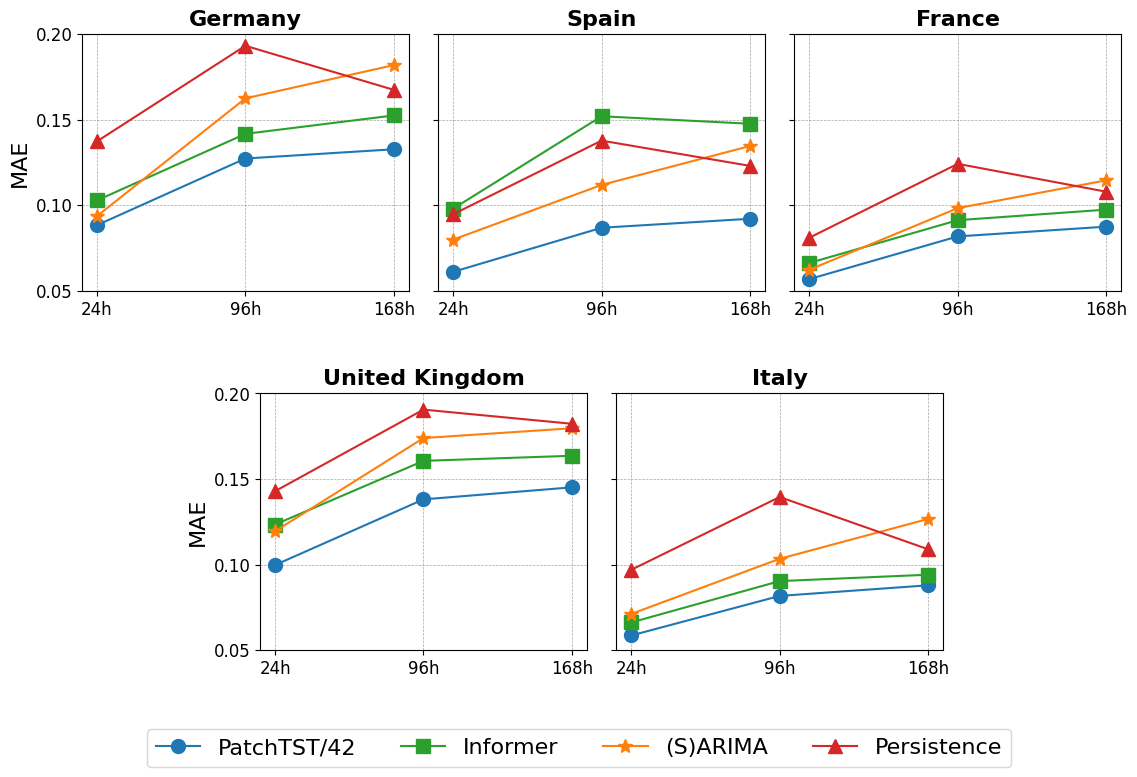

In [5]:
plot_results_models_multiple_countries(all_df, 
                                       function="lines", 
                                       eval_metric='MAE',
                                       decimal_places=2
                                       )

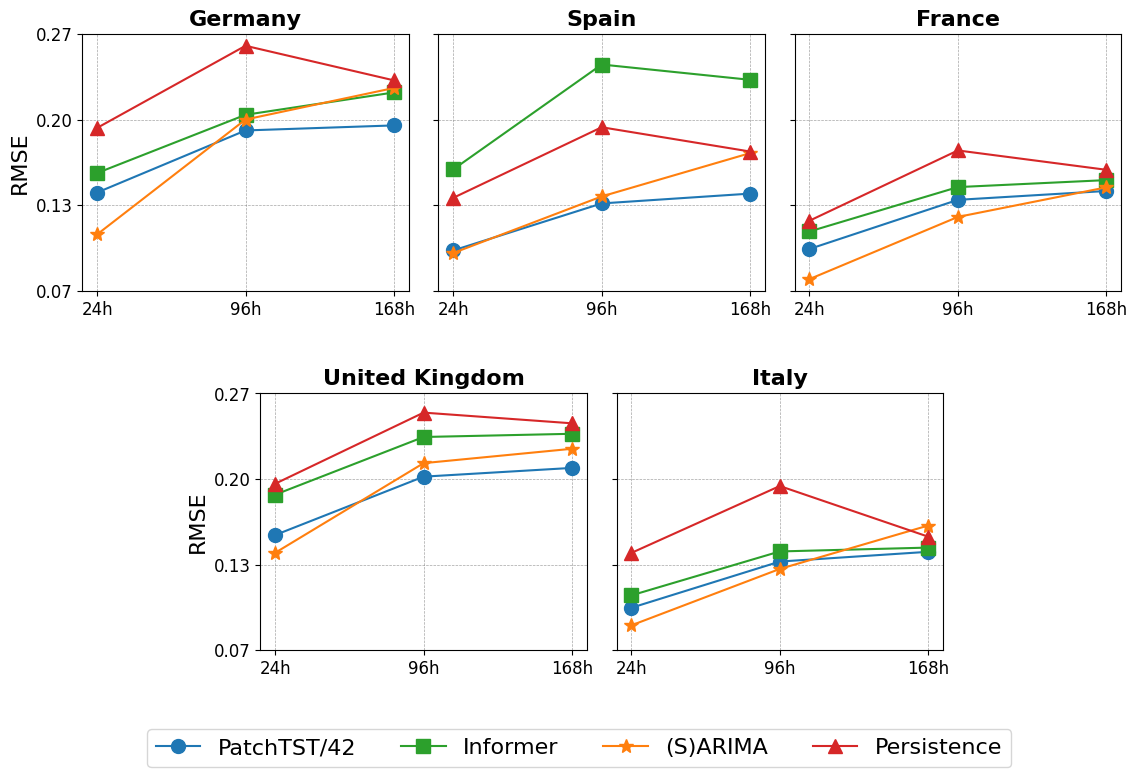

In [6]:
plot_results_models_multiple_countries(all_df, 
                                       function="lines", 
                                       eval_metric='RMSE',
                                       decimal_places=2)

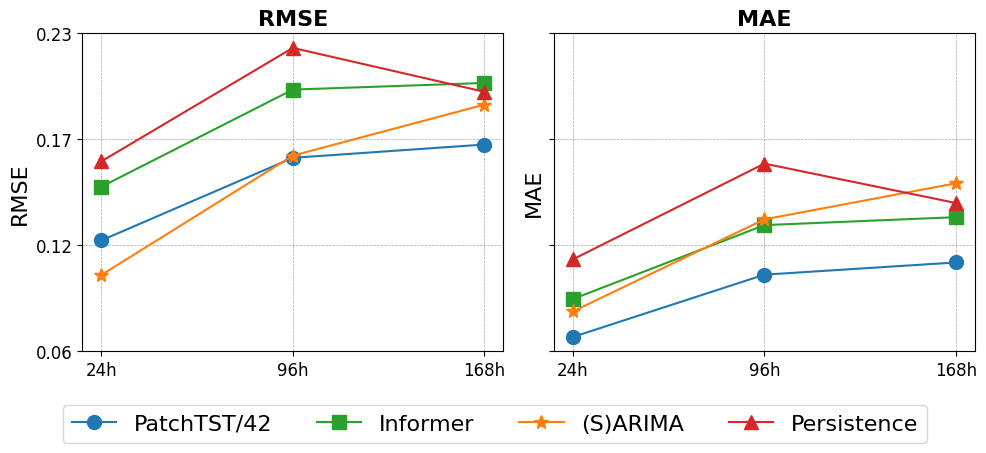

In [7]:
# Averaged by pred_len
to_group = 'Pred_len'
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_comparison_for_metrics(grouped_means, plot_x_axis=to_group, plot_type="lines")

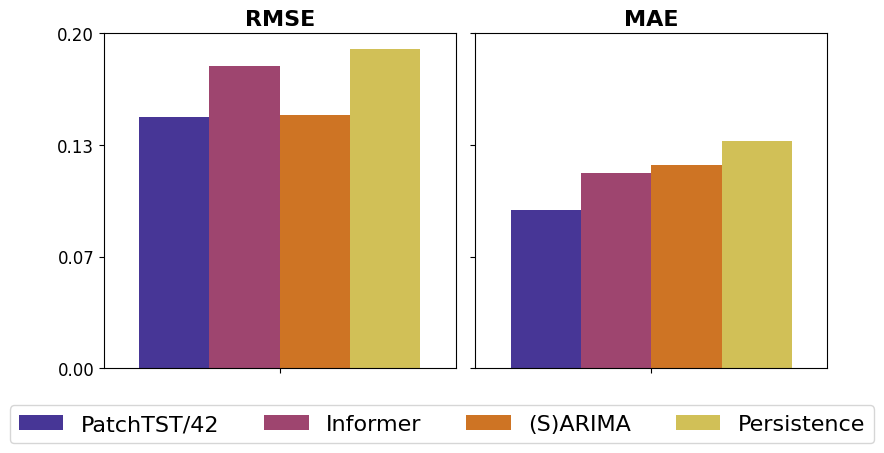

In [8]:
to_group = ['Country', 'Pred_len']
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_barplots(grouped_means, 'Model', col_name='Metrics', palette='CMRmap')

In [9]:
# Calculate improvement over second best models
informer_mae = grouped_means.loc[
    (grouped_means['Model'] == 'Informer') & (grouped_means['Metrics'] == 'MAE'), 'Value'
].values

patchtst_mae = grouped_means.loc[
    (grouped_means['Model'] == 'PatchTST/42') & (grouped_means['Metrics'] == 'MAE'), 'Value'
].values
improvement_percentage_mae = ((informer_mae - patchtst_mae) / informer_mae * 100)[0].round(2)
print('Improvement of PatchTST over second-best model (Informer) in terms of MAE: {} %'.format(improvement_percentage_mae)) 

arima_rmse = grouped_means.loc[
    (grouped_means['Model'] == '(S)ARIMA') & (grouped_means['Metrics'] == 'RMSE'), 'Value'
].values

patchtst_rmse = grouped_means.loc[
    (grouped_means['Model'] == 'PatchTST/42') & (grouped_means['Metrics'] == 'RMSE'), 'Value'
].values
improvement_percentage_rmse = ((arima_rmse - patchtst_rmse) / arima_rmse * 100)[0].round(2)
print('Improvement of PatchTST over second-best model ((S)ARIMA) in terms of MSE: {} %'.format(improvement_percentage_rmse)) 

Improvement of PatchTST over second-best model (Informer) in terms of MAE: 19.12 %
Improvement of PatchTST over second-best model ((S)ARIMA) in terms of MSE: 0.84 %


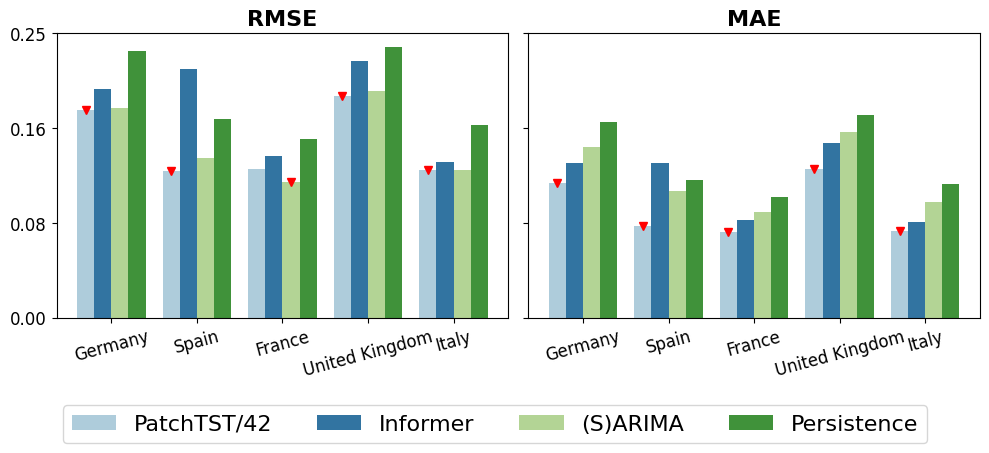

In [10]:
# Averaged by country
to_group = 'Country'
grouped_means = group_and_reindex_df(all_df)
plot_comparison_for_metrics(grouped_means, plot_x_axis=to_group, plot_min_markers=True, plot_max_markers=False, palette="Paired")

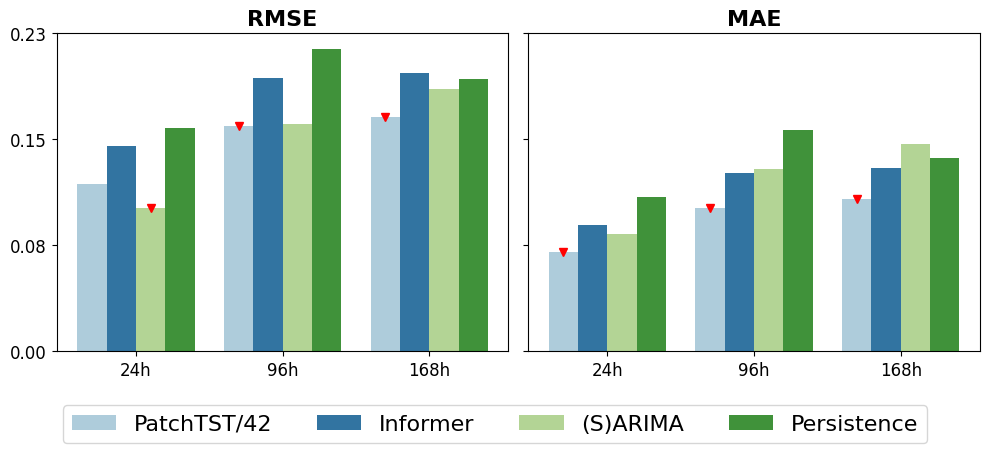

In [12]:
# Averaged by pred_len
to_group = 'Pred_len'
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_comparison_for_metrics(grouped_means, plot_x_axis=to_group, plot_min_markers=True, palette="Paired")

# 2. Input length 512

In [13]:
all_df = pd.concat([patchtst_64_df, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)
# Scale
all_df_scale = all_df * scale

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [43]:
# Averaged by pred_len
to_group = ['Pred_len', 'Country']
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
grouped_means

,Model,Metrics,Value
0,PatchTST/64,RMSE,0.150189
1,PatchTST/64,MAE,0.094858
2,PatchTST/42,RMSE,0.150498
3,PatchTST/42,MAE,0.094652


In [ ]:
# Averaged by pred_len
to_group = 'Pred_len'
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
grouped_means = grouped_means.stack(level=0).reset_index()
grouped_means = pd.melt(grouped_means, id_vars=['Pred_len', 'Model'],# 'Pred_len', 
                        value_vars=['RMSE', 'MAE'], 
                        var_name='Metrics', 
                        value_name='Value')
grouped_means

,Pred_len,Model,Metrics,Value
0,24,PatchTST/42,RMSE,0.120428
1,24,PatchTST/64,RMSE,0.120402
2,96,PatchTST/42,RMSE,0.162178
3,96,PatchTST/64,RMSE,0.161665
4,168,PatchTST/42,RMSE,0.168887
5,168,PatchTST/64,RMSE,0.168501
6,24,PatchTST/42,MAE,0.071602
7,24,PatchTST/64,MAE,0.071835
8,96,PatchTST/42,MAE,0.103093
9,96,PatchTST/64,MAE,0.103119


([0, 1], [Text(0, 0, 'PatchTST/42'), Text(1, 0, 'PatchTST/64')])

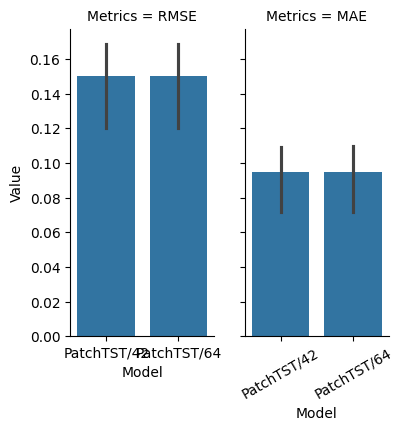

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.catplot(
    grouped_means, kind="bar",
    x="Model", y="Value", col="Metrics",
    height=4, aspect=.5,
)
plt.xticks(rotation=30)

In [18]:
styled_df.to_html(os.path.join(path, 'input_512_10_power_2.html'), index=True)

# 3. Self-supervised

In [19]:
# Read data
self_supervised = read_results_csv('patchtst/finetune_results.csv',
                                    columns_to_extract = ('Self-supervised', ['RMSE', 'MAE'])
                                    )

all_df = pd.concat([self_supervised, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)
# Scale
all_df_scale = all_df * scale

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [20]:
styled_df.to_html(os.path.join(path, 'self_supervised_10_power_2.html'), index=True)

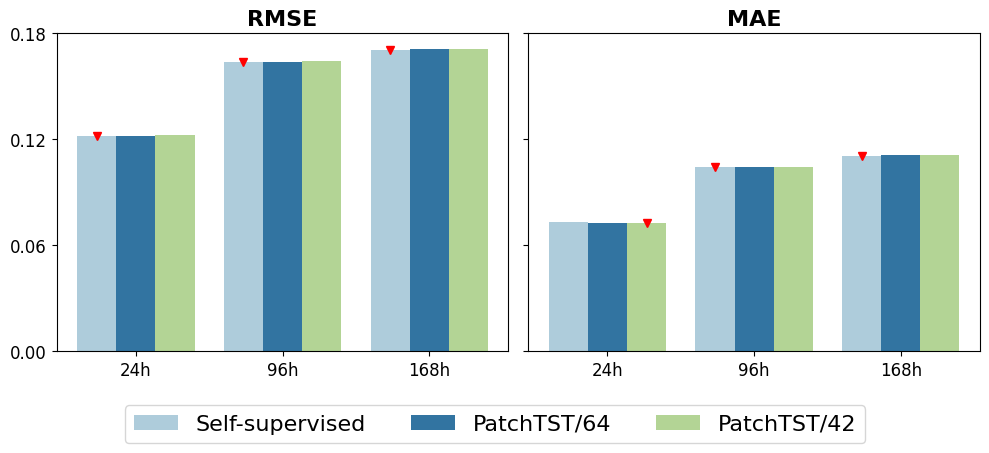

In [ ]:
# all together
# Not visible

all_df = pd.concat([self_supervised, patchtst_64_df, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Averaged by country
to_group = 'Pred_len'
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_comparison_for_metrics(grouped_means, plot_x_axis=to_group, plot_min_markers=True, plot_max_markers=False, palette="Paired")

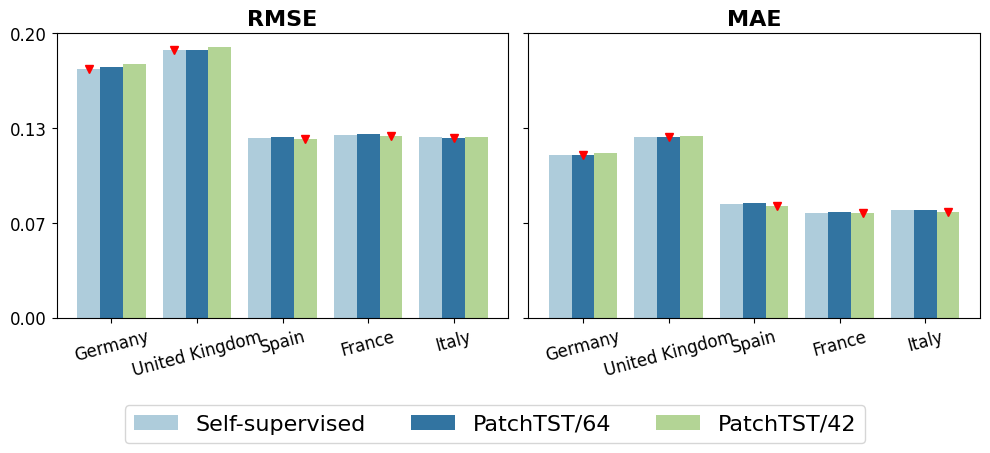

In [22]:
# Averaged by country
to_group = 'Country'
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_comparison_for_metrics(grouped_means, plot_x_axis=to_group, plot_min_markers=True, plot_max_markers=False, palette="Paired")

# 3. Ablation study

In [23]:
# Read data
no_revin = read_results_csv('patchtst/patchtst_no_revin.csv', 
                           columns_to_extract = ('-RevIN', ['RMSE', 'MAE'])
                           )
channel_mix = read_results_csv('patchtst/patchtst_channel_mixing.csv', 
                              columns_to_extract = ('CM', ['RMSE', 'MAE'])
                              )
patchtst_mix_features = read_results_csv('patchtst/patchtst_channel_mixing_MIX_FEATURES.csv',
                                        columns_to_extract = ('CM', ['RMSE', 'MAE'])
                                        )
no_patch = read_results_csv('patchtst/patchtst_no_patching.csv', 
                           columns_to_extract = ('-P', ['RMSE', 'MAE'])
                           )

all_df = pd.concat([patchtst_df, no_revin, patchtst_mix_features, no_patch], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight maximum values in bold
styled_df = style_dataframe(all_df_scale, 'max', decimal_places=2)
styled_df

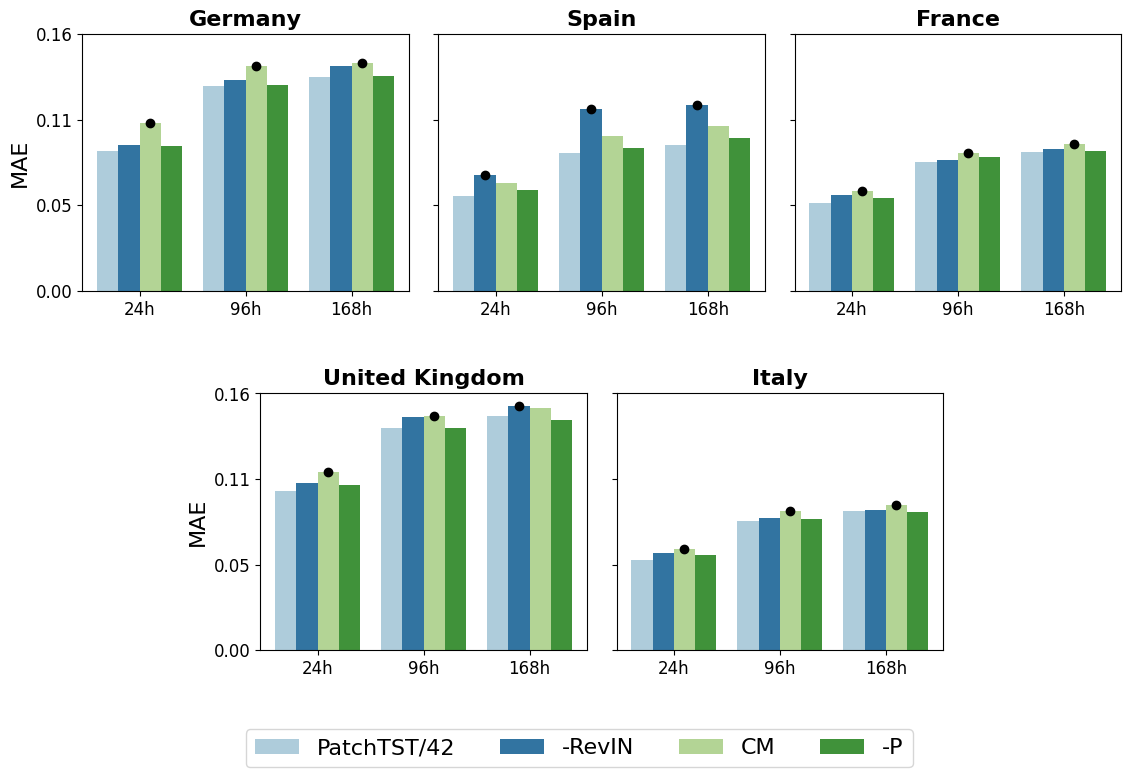

In [24]:
plot_results_models_multiple_countries(all_df, 
                                       function="bars", 
                                       eval_metric='MAE',
                                       palette="Paired",
                                       plot_max_markers=True,
                                       decimal_places=2)

In [26]:
styled_df.to_html(os.path.join(path, 'ablation_10_power_2.html'), index=True)

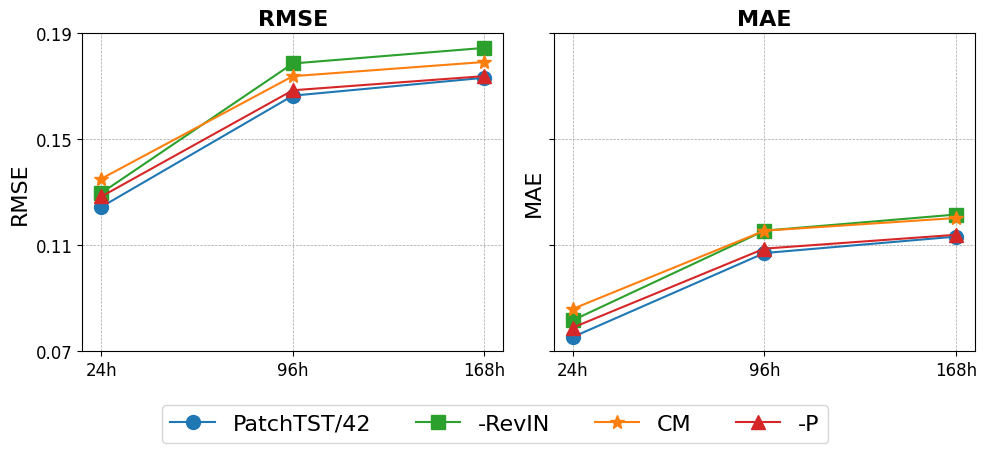

In [27]:
# Averaged by country
# Not clearly visible
to_group = 'Pred_len'
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_comparison_for_metrics(grouped_means, plot_type="lines")

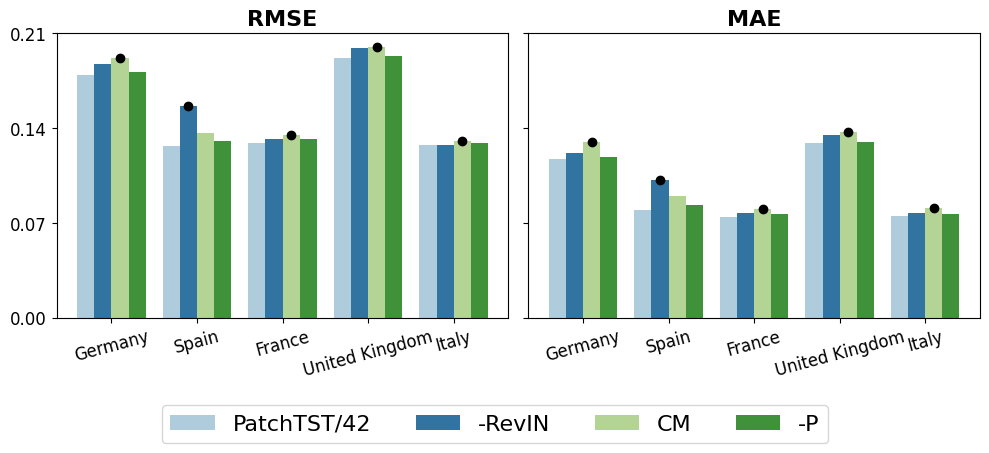

In [31]:
# Averaged by country
to_group = 'Country'
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_comparison_for_metrics(grouped_means,
                             plot_x_axis=to_group, 
                             plot_max_markers=True,
                             palette="Paired")

# 4. TimeLLM

In [42]:
timellm_df = read_results_csv('timellm/timellm.csv', 
                              columns_to_extract = ('TimeLLM/512', ['RMSE', 'MAE'])
                              )
timellm_df_336 = read_results_csv('timellm/timellm_336.csv', 
                              columns_to_extract = ('TimeLLM/336', ['RMSE', 'MAE'])
                              )
all_df = pd.concat([timellm_df, timellm_df_336, patchtst_64_df, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

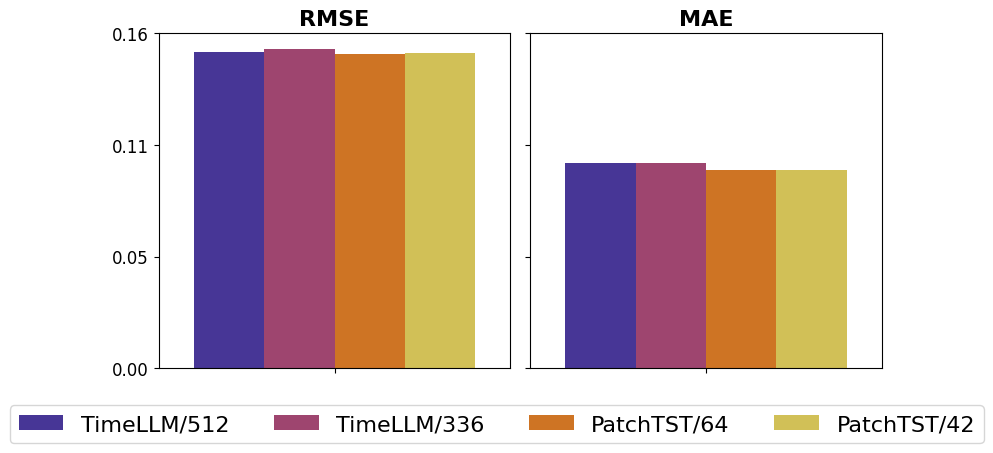

In [43]:
to_group = ['Country', 'Pred_len']
grouped_means = group_and_reindex_df(all_df, to_group=to_group)
plot_barplots(grouped_means, 'Model', col_name='Metrics', palette='CMRmap')

In [ ]:
styled_df.to_html(os.path.join(path, 'timellm_512_10_power_2.html'), index=True)

In [35]:
all_df = pd.concat([timellm_df, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [37]:
all_df = pd.concat([timellm_df_336, patchtst_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

In [38]:
all_df = pd.concat([timellm_df_336, timellm_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df

# 5. Decomposition

In [ ]:
decomposition_df = read_results_csv('patchtst/patchtst_decomposition.csv', 
                                    columns_to_extract=('Decomposition', ['RMSE', 'MAE'])
                                    )

all_df = pd.concat([patchtst_df, decomposition_df], axis=1)

# Change country codes to country names
all_df.index = pd.MultiIndex.from_tuples(
    [(map_country_name(x[0]), x[1]) for x in all_df.index],
    names=level_names
)

# Scale
all_df_scale = all_df * scale

# Highlight the minimum values in bold
styled_df = style_dataframe(all_df_scale, decimal_places=2)
styled_df